# Green optimization on a quantum annealer
## A cost-efficient optimization of energy networks to reduce carbon emissions

Optimal scheduling of multiple energy sources (or generators) of a network is one of the most popular and critical optimization problems in the electrical power industry for the operations of power systems [[1]](https://link.springer.com/content/pdf/10.1007/s11708-013-0240-3.pdf). 

This problem is also known as Unit commitment (UC) and it is generally formulated as a large-scale mixed integer nonlinear problem. Solving UC is very difficult due to the nonlinear cost function and the combinatorial nature of set of feasible solutions. It has been proven that UC is not only NP-hard but also NP-complete.

There have been some attempts in solving some version of the UC problem on a quantum computer [[2]](https://arxiv.org/abs/2003.00254), however in this project we address a different type of performance metric, which is not solely based on finding an optimal schedule to reduce costs, but also on the reduction of the carbon emission. 

Green optimization (optimization of a problem involving a sustainable metric) is applied to utilities, logistics and supply-chain ecosystem [[3]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0132997)[[4]](https://www.mdpi.com/2076-3417/9/8/1611)[[5]](https://pure.tue.nl/ws/files/3805505/781632.pdf)[[6]](https://ieeexplore.ieee.org/document/6517783). Generally, the framework is based on a multi-objective optimization to find the Pareto forntier of the optimal solutions which satisfy both a minimization of the costs and the minimization of the sustainable performance metric (e.g. carbon emission). 

In this work we use a Quantum Computing approach to solve the Green optimization in the context of utlities. Our goal is to find an optimal schedule for several energy sources for a utility network. The green optimization is implemented by looking at the trade off between cost of usage and carbon emission costs (in terms of Renewable Energy Certificates). 

In the following we formulate the optimization problem as a QUBO problem, describe the data input for the determination of the load demand schedule and the costs and solve it with the D-Wave Leap Hybrid solver. We then compare the results to a classical method (simulated annealing) using the neal D-Wave package. Finally we construct a simpler problem (smaller network and few stp demand schedule) that can be solved directly on the QPU and compare the results to the Exact solver and an implementation of the same QUBO problem with QAOA in Qiskit.

## Problem definition: variables, objective and constraints

The first step in determining an optimal solution of the problem is to clearly define the variables, objective and constraints of the optimization.

The goal of the optimization is to find an optimal distribution of fossil and renewable energy sources in a network, to minimize costs (operating, switching and carbon emission related) while satisfying a given power demand schedule.

We consider a schedule with hourly granularity, for a period that can vary from few hours ahead up to a quarter. 
At each hour in the schedule, several energy sources (fossil and renewable) can be used to satisfy the given power demand. 
Thus, we can define the variables of the problem as binary variables $s_{i\alpha}$, where $i$ is the time point in the schedule and $\alpha$ is the energy source (e.g. gas, coal, wind, solar, etc.), such that:
- $s_{i\alpha} = 1$, if the energy source $\alpha$ is active at time $i$
- $s_{i\alpha} = 0$, otherwise.

Given these variables, the objective function to be minimized will be the sum of the costs (operating, switching and carbon emission related) for the active energy sources which are active at each time in the schedule.

This **objective** can be split in two components (in the following, greek indices refer to the energy sources, while roman indices to the time schedule): 
- a **linear component** which takes care of the operating and carbon emission related costs:
$$H_{L} = \sum_{i,\alpha}(c^\alpha_o + c^\alpha_e)\cdot s_{i\alpha},$$
where $c^\alpha_o$ is the operating cost per hour for the energy source $\alpha$ and $c^\alpha_e$ is the cost per hour related to the carbon emission for the energy source $\alpha$. The latter is proxied by the carbon emission taxes or the cost of renewable certificates.
- a **quadratic term**, which entails the correlation between the switching from one energy source to another for two consecutive times in the schedule:
$$H_{Q} = \sum_{i,\alpha,\beta}(c^\alpha_{off} + c^\beta_{on})\cdot s_{i,\alpha}s_{i+1,\beta},$$
where $c^\alpha_{off}$ ($c^\alpha_{on}$) is the cost of switching off (on) the energy source $\alpha$. For the sake of simplicity, we assume in the following that the cost to switch the energy source off and on is the same: 
$$c^\alpha_s \equiv c^\alpha_{off} = c^\alpha_{on}.$$
Note that in $H_{Q}$ the index $i$ does not include the last schedule.

If we only consider the objective of minimizing costs, the trivial solution to the problem is to keep all energy sources always switched off. In reality, the energy network needs to satisfy a power demand schedule, which is generally forecasted based on multiple factors inlcuding hour of the day, season, weather forecast, commodity prices, etc.

The **constraint** can then be expressed as a linear inequality constraint such that the power generated by all sources at time $i$ must meet the power demand at the same time:
$$\sum_{\alpha}p_\alpha\cdot s_{i\alpha} - d_i \geq 0,$$
where $p_\alpha$ is the power generated by the energy source $\alpha$ and $d_i$ is the total power demand at time $i$.

In conclusion, the QUBO problem can finally be forumlated as follows:
$$\min(H_{L} + H_{Q})$$
$$ s.t.~\sum_{\alpha}p_\alpha\cdot s_{i\alpha} - d_i \geq 0$$

## Implementation on QUBO via BinaryQuadraticModel

In the following we show how to solve the problem above in the QUBO formulation on D-Wave. 

We constructed a class (EnergyBQM) to wrap the construction of the variables, the objective and the constraint and include some plotting features. 

See file [BQM.py](./src/utils/BQM.py) for the implementation.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from src.utils.BQM import EnergyBQM


# fix the random seed
np.random.seed(123)

## Input data

The first step for the definition of a realistic use case is to investigate the data input for the optimization problem.
The data to be used can be classified in:
1. inputs regarding the power demand and 
2. inputs regarding the energy sources.

#### Power demand data
Regarding the power demand, a demand schedule needs to be defined. 

In order to have a realistic proxy for the power demand schedule, we looked at actual hourly data of load values for a country (Italy) and defined a sintetic power demand schedule by scaling down the country-wise demand schedule to the maximum capacity of the energy network we define.

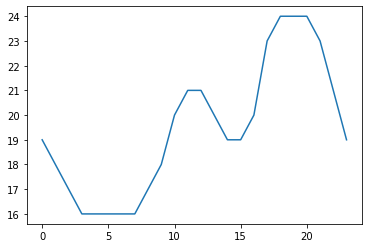

In [2]:
# Assume looking at the future 24 hours
n_schedules = 24

# define binary variables
schedules = [f's_{i}' for i in range(n_schedules)]

# read in the hourly load values for a single year
demand_data = pd.read_excel('./data/Monthly-hourly-load-values_2014_IT.xlsx')

# collect the demand data for the year into a list
demand = []
for i in range(len(demand_data)):
    demand += list((demand_data.iloc[i,6:]))

# scaling down demand to size of problem to obtain a range of values compatible with our energy network
demand_schedule = [int(40*i/max(demand)) for i in demand[0:n_schedules]]  

# Plot demand schedule for a single day (24h)
plt.plot(demand_schedule[0:24], label='demand')
plt.show()

#### Energy source data
Based on the QUBO formulation outlined above, for each energy source we need to define the following features:
- **operational cost**: cost per hour of using the given energy source. These costs are obtained for different energy sources (fossil and renewable) from the average operating costs on the [US Energy Information Administration webpage](https://www.eia.gov/electricity/annual/html/epa_08_04.html). These costs include operation, maintenance and fuel related costs.
- **carbon emission costs**: in several countries, companies including energy providers are obliged to keep the levels of CO$_2$ below certain thresholds. The usual mechanism to provide an incentive for the companies to reduce their carbon emission is via carbon emission taxation (e.g. Europe) or buying renewable energy certificates, depending on the produced carbon footprint. For the sake of the calculation, in this notebook we assume these costs to be proportional to the carbon emission per hour. 
- **cost of switching on/off**: these costs are responsible for the correlation term in the QUBO framework. We obtained 
- **capacity**: this is the power generated per hour by an energy source (see [EIA](https://www.eia.gov/)). 

<!-- 50 MWh [gas](https://documents1.worldbank.org/curated/en/640981468780885410/pdf/263500Energy0issues020.pdf)
3 MWh [wind](https://www.irena.org/wind#:~:text=Today's%20new%20wind%20power%20projects,to%202%20MW%20in%202014.)
2 MWh [solar](https://www.eia.gov/todayinenergy/detail.php?id=38272#:~:text=The%20average%20community%20solar%20facility%20has%20a%20capacity%20of%202.0%20MW).
10 MWh [hydro](https://www.sciencedirect.com/topics/engineering/hydropower-plant)
 -->

#### Network design

For the pursposes of this implementation we consider a network composed by the following energy sources:
- fossil (e.g. coal or gas)
- wind
- solar
- hydro

The first is a generic non-renewable energy source, while the last three are renewable. 

We consider a first implementation example in which the network is composed by a single plant for energy source.
A more realistic network with additional power plants, e.g. with different costs and capacity can be easily extended from the current model.

For simplicity in the following we consider natural gas as the fossil source.

In [3]:
# Gas 'g', Hydro 'h', Solar 's', Wind 'w'
sources = ['g', 'h', 's', 'w']

# Operating costs by plant type(Operation,Maintenance,Fuel) mills per kwh (see https://www.eia.gov/electricity/annual/html/epa_08_04.html)

operating_costs = [('g', 30),
                   ('h', 15),
                   ('s', 10),
                   ('w', 10)]

# define the cost of usage (total operating costs)
cost_usage = [operating_costs[i][1] for i in range(len(operating_costs))]

# define the cost to switch off/on one of the energy sources
cost_switch = [10, 5, 1, 1]

# define the carbon emission cost per kWh (proxied by cost/kWh of the Solar Renewable Energy Certificates (RECs) in US)
cost_emission = [10, 5, 1, 2]

# define the max power generation per kWh per source and plant
capacity = [50, 10, 3, 8]

We then store all the information and input data about the schedule and the sources into a context dictionary, to be input to the EnergyBQM class in [BQM.py](./src/utils/BQM.py)

In [4]:
context = {}
context['schedules'] = schedules
context['demand_schedule'] = demand_schedule

context['sources'] = sources
context['cost_usage'] = cost_usage
context['cost_switch'] = cost_switch
context['cost_emission'] = cost_emission
context['capacity'] = capacity

Finally, we can build and solve our BQM problem. Given the size of the problem, we use the **Leap Hybrid Sampler**. 

In [5]:
# define BQM
bqm = EnergyBQM(context)

res = bqm.solve_with_LeapHybridSampler(verbose=True)

elapsed time (Leap Hybrid sampler):  0:00:04.436001
  s_0g s_0h s_0s s_0w s_10g s_10h s_10s s_10w s_11g ... s_9w  energy num_oc.
0    0    1    0    1     0     1     1     1     0 ...    1 30847.0       1
['BINARY', 1 rows, 1 samples, 96 variables]


The obtained results can be then plot to a graph to verify that the network satisfies the power demand given by the schedule.

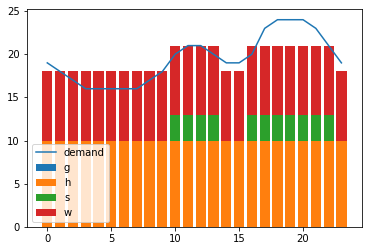

In [6]:
bqm.plot_results()

## Observations

The current optimization problem aims to find the an optimal distribution of fossil and renewable energy sources in a network, to minimize costs (operating, switching and carbon emission related) while satisfying a given power demand schedule.

For the chosen realistic demand schedule and the values of the capacity of the single energy sources, it appears that the optimum for this toy model is reached by using only renewable energy sources.

An extension to a **larger amount of energy sources and more realistic scenarios for the renewable energy sources** has been performed in 
[this notebook](./Green_optimization_QuantumAnnealing_XL.ipynb).

#### Comparison: simulated annealing

Once the results from the quantum hybrid solver have been obtained, we can compare them to the results obtained with the simulated annealing. 

The simulated (thermal) annealing is a heuristic optimization procedure which spans the solution space of a generic optimization problem by simulating the physical process of heating a material and then slowly lowering the temperature to decrease defects, thus minimizing the system energy. Each transition in spanning the solution space is called anneal.

We use the SimulatedAnnealingSampler in the D-Wave neal package to solve the same bqm.
The function solve_with_SimulatedAnnealingSampler is a wrapper to the D-Wave one.

In [7]:
classical_res = bqm.solve_with_SimulatedAnnealingSampler(verbose=True)

Elapsed time (simulated annealing):  0:00:00.023000
  s_0g s_0h s_0s s_0w s_10g s_10h s_10s s_10w s_11g ... s_9w  energy num_oc.
0    0    1    0    1     0     1     1     1     0 ...    1 31835.0       1
['BINARY', 1 rows, 1 samples, 96 variables]


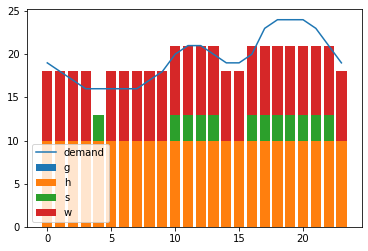

In [8]:
bqm.plot_results()

As we can see, the result is very similar to the case of the quantum hybrid solver, except for t=4, for which the constraint in the case of the simulated annealing is not satisfied.

#### Comparison: Leap, ExactSolver, D-Wave QPU and QAOA 

Finally, our goal was to compare results from the D-Wave hybrid solver for the problem at hand with: 
1. the solution obtained by solving the problem onto a QPU
2. the solution obtained with a different algorithm, QAOA

However the problem at hand is too complex for both tasks. Thus, we simplified the problem to include only a small amount of time slot in the schedule and a small amount of energy sources.

For this reson we choose a 4 instant schedule and 3 energy sources (fossil, wind and solar).

In [9]:
# Assume 4 steps in the schedule
n_schedules = 4

# define binary variables
schedules = [f's_{i}' for i in range(n_schedules)]

# define a syntetic load demand schedule
demand_schedule = [15, 12, 20, 5]  


# Gas 'g', Solar 's', Wind 'w'
sources = ['g', 's', 'w']

# define syntetic cost of usage (total operating costs)
cost_usage = [30, 5, 10]

# define the cost to switch off/on one of the energy sources
cost_switch = [5, 1, 1]

# define the carbon emission cost per kWh (proxied by cost/kWh of the Solar Renewable Energy Certificates (RECs) in US)
cost_emission = [5, 1, 2]

# define the max power generation per kWh per source and plant
capacity = [15, 7, 10]

# define context for BQM 
context = {}
context['schedules'] = schedules
context['demand_schedule'] = demand_schedule

context['sources'] = sources
context['cost_usage'] = cost_usage
context['cost_switch'] = cost_switch
context['cost_emission'] = cost_emission
context['capacity'] = capacity

In the following we solve the problem on the QPU, by using the wrapper of the DWaveSampler.

In [10]:
# define BQM
bqm = EnergyBQM(context)

res = bqm.solve_with_QPU()

Elapsed time (QPU - Chimera):  0:00:00.113529
  s_0g s_0s s_0w s_1g s_1s s_1w s_2g s_2s s_2w s_3g ... s_3w energy num_oc. ...
0    0    1    1    0    0    1    1    1    0    0 ...    1 6862.0       1 ...
['BINARY', 1 rows, 1 samples, 12 variables]


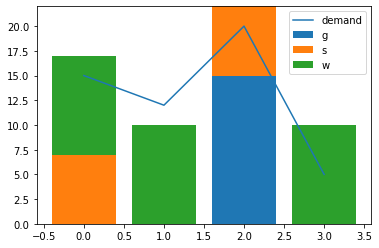

In [11]:
bqm.plot_results()

And subsequently test it onto the Exact solver:

In [12]:
# define BQM
bqm = EnergyBQM(context)

res = bqm.solve_with_ExactSampler()

Elapsed time (Exact solver):  0:00:00.058002
Sample(sample={'s_0g': 1, 's_0s': 0, 's_0w': 0, 's_1g': 0, 's_1s': 0, 's_1w': 1, 's_2g': 1, 's_2s': 1, 's_2w': 0, 's_3g': 0, 's_3s': 1, 's_3w': 0}, energy=3339.0, num_occurrences=1)


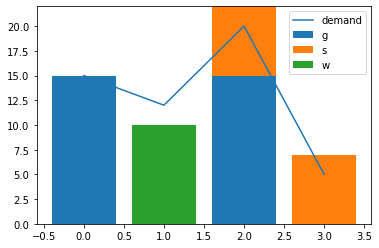

In [13]:
bqm.plot_results()

Finally we implemented the same QUBO problem with QAOA by using:
1. PyQuil framework (Rigetti)
2. IBM Qiskit

Results with the Rigetti framework are available in [this notebook](./Green_optimization_QuantumAnnealing_QAOA_Rigetti.ipynb).
Results with Qiskit are available [here](./Green_optimization_QuantumAnnealing_QAOA_IBM.ipynb).

For this calculation, the values of the QUBO coefficient for the linear and the quadratic terms are obtained from the implemented BQM problem in D-Wave:

In [14]:
print(bqm.bqm.linear)
print(bqm.bqm.quadratic)

{'s_0g': -33225.0, 's_0s': -24060.0, 's_0w': -29820.0, 's_1g': -19830.0, 's_1s': -17778.0, 's_1w': -20856.0, 's_2g': -55550.0, 's_2s': -34530.0, 's_2w': -44760.0, 's_3g': 11425.0, 's_3s': -3120.0, 's_3w': 60.0}
{('s_0s', 's_0g'): 31500.0, ('s_0w', 's_0g'): 45000.0, ('s_0w', 's_0s'): 21000.0, ('s_1g', 's_0s'): 6.0, ('s_1g', 's_0w'): 6.0, ('s_1s', 's_0g'): 6.0, ('s_1s', 's_0w'): 2.0, ('s_1s', 's_1g'): 31500.0, ('s_1w', 's_0g'): 6.0, ('s_1w', 's_0s'): 2.0, ('s_1w', 's_1g'): 45000.0, ('s_1w', 's_1s'): 21000.0, ('s_2g', 's_1s'): 6.0, ('s_2g', 's_1w'): 6.0, ('s_2s', 's_1g'): 6.0, ('s_2s', 's_1w'): 2.0, ('s_2s', 's_2g'): 31500.0, ('s_2w', 's_1g'): 6.0, ('s_2w', 's_1s'): 2.0, ('s_2w', 's_2g'): 45000.0, ('s_2w', 's_2s'): 21000.0, ('s_3g', 's_2s'): 6.0, ('s_3g', 's_2w'): 6.0, ('s_3s', 's_2g'): 6.0, ('s_3s', 's_2w'): 2.0, ('s_3s', 's_3g'): 31500.0, ('s_3w', 's_2g'): 6.0, ('s_3w', 's_2s'): 2.0, ('s_3w', 's_3g'): 45000.0, ('s_3w', 's_3s'): 21000.0}


## References

[[1]](https://link.springer.com/content/pdf/10.1007/s11708-013-0240-3.pdf) A solution to the unit commitment problem—a review

[[2]](https://arxiv.org/abs/2003.00254) Quantum computing for energy systems optimization: Challenges and opportunities

[[3]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0132997) Optimizing Cellular Networks Enabled with Renewal Energy via Strategic Learning

[[4]](https://www.mdpi.com/2076-3417/9/8/1611) Unit Commitment Accommodating Large Scale Green Power

[[5]](https://pure.tue.nl/ws/files/3805505/781632.pdf) SMART energy homes and the smart grid: a framework for
intelligent energy management systems for residential customers

[[6]](https://ieeexplore.ieee.org/document/6517783) On Optimizing Green Energy Utilization for Cellular Networks with Hybrid Energy Supplies

[[7]](https://www.eia.gov/) US Energy Information Administration